# Schedule Losses

- Let's use another variable, let's call it days-of-rest. See what that does for us.

In [130]:
import matplotlib.pyplot as plt
import matplotlib.style as style
import numpy as np
import os
import pandas as pd
import pendulum
from scipy import stats
import seaborn as sns
import statsmodels.api as sm
import warnings
warnings.filterwarnings('ignore')

import utils

In [111]:
back_to_backs = (
    pd.read_csv('../data/NBA Scores and Point Spreads.csv')
    .sort_values(
        by=['team', 'dt']
    )
    .assign(
        dt = lambda x: x['dt'].apply(utils.clean_date),
        last_game = lambda x: x.groupby(['team', 'season'])['dt'].shift(1),
        date_delta = lambda x: (x['dt'] - x['last_game']).transform(lambda s: s.days),
        back_to_back = lambda x: x['date_delta'].transform(lambda s: 1 if s == 1 else 0)
    )
    [['team', 'season', 'dt', 'date_delta', 'back_to_back', 'game_id']]
)

## Summary Stats

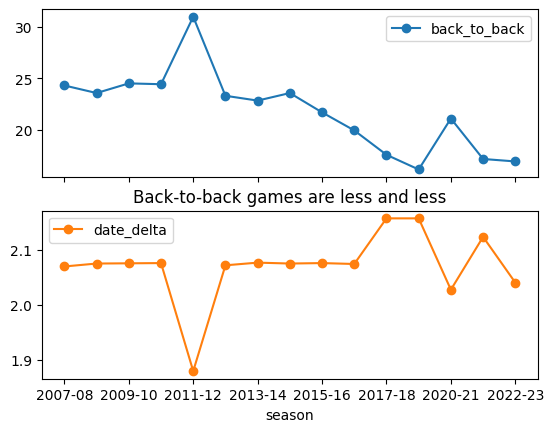

In [112]:
(
    back_to_backs
    .groupby(['season'])
    .agg(
        back_to_back = ('back_to_back', 'mean'),
        date_delta = ('date_delta', 'mean')
    )
    .reset_index()
    .query('season != "2019-20"')
    .assign(
        back_to_back = lambda x: 100 * x['back_to_back']
    )
    .plot(
        x='season',
        subplots=True,
        marker='o'
    )
)

plt.title('Back-to-back games are less and less')
plt.show()

## Model

In [113]:
rolling_movs = (
    df
    .sort_values(by=['team', 'season', 'game_number'])
    .assign(
        cumulative_mov = lambda x: x.groupby(['team', 'season'])['mov'].cumsum(),
        rolling_mov = lambda x: x['cumulative_mov'] / x['game_number'],
        pre_game_mov = lambda x: x.groupby(['season', 'team'])['rolling_mov'].shift(1),
    )
)

predictions = (
    rolling_movs
    .pivot_table(
        index=['game_id'],
        columns='home_away',
        values='rolling_mov'
    )
    .reset_index()
    .merge(
        rolling_movs,
        on='game_id',
        how='left'
    )
    .query('home_away == "Home"')
    .assign(
        pre_game_mov_delta = lambda x: x['Home'] - x['Away']
    )
    .query('game_number >= 20')
    .query('game_number <= 82')
    [['game_id', 'Away', 'Home', 'team', 'opponent', 'point_spread', 'season', 'mov', 'pre_game_mov_delta']]
)

In [125]:
data = (
    df
    [['team', 'opponent', 'game_id', 'home_away']]
    .sort_values(by='game_id')
    .merge(
        back_to_backs[['team', 'back_to_back', 'game_id']],
        on=['game_id', 'team'],
        how='left'
    )
    .pivot_table(
        index='game_id',
        columns='home_away',
        values='back_to_back'
    )
    .reset_index()
    .assign(
        back_to_back_advantage = lambda x: x['Home'] - x['Away']
    )
    .fillna(0)
    [['game_id', 'back_to_back_advantage']]
    .merge(
        predictions,
        on='game_id',
        how='right'
    )
    .assign(
        point_spread = lambda x: x['point_spread'] * -1
    )
)

In [126]:
data

,game_id,back_to_back_advantage,Away,Home,team,opponent,point_spread,season,mov,pre_game_mov_delta
0,00004c0fcb8737eda21ad0bf471fb313,-1.0,2.032258,-6.575758,Minnesota,Denver,3.0,2010-11,-6,-8.608016
1,0003b7d6f3e13ef62d4c52f2bba13bfb,0.0,-1.238806,5.246377,Boston,Sacramento,8.0,2018-19,6,6.485183
2,000459ce4258b763cc69835815de2ed1,1.0,-2.120000,-10.807692,Philadelphia,Charlotte,-8.0,2014-15,8,-8.687692
3,00065fa8294eff0f8af256d96e5e5eb3,0.0,2.176471,-5.375000,Chicago,OklahomaCity,2.5,2009-10,-13,-7.551471
4,000a456ce41df7390565ee0fd450284a,0.0,0.900000,-1.600000,Denver,Philadelphia,5.0,2019-20,3,-2.500000
...,...,...,...,...,...,...,...,...,...,...
13892,ffd94973c6727c78f0d08c8b099cccc7,1.0,-6.951220,2.341463,Nets,OklahomaCity,5.5,2021-22,-21,9.292683
13893,ffdafc5dc8e7c417364fb6592a123456,-1.0,-5.375000,2.625000,Indiana,NewOrleans,10.0,2011-12,9,8.000000
13894,ffed896df673489e928e1c48f6c995da,NaN,2.369863,5.958904,LAClippers,Dallas,6.0,2020-21,-10,3.589041
13895,ffeebbbde31ff209a61bbd131d67bf62,0.0,-3.102041,3.000000,Utah,Sacramento,9.0,2019-20,22,6.102041


In [128]:
response_variables = ['mov', 'point_spread']
seasons = df.season.unique().tolist()

model_results = []

for season in seasons:
    for response_variable in response_variables:
        X = data.query(f'season == "{season}"')[['back_to_back_advantage', 'pre_game_mov_delta']].fillna(0)
        X = sm.add_constant(X)
        y =  data.query(f'season == "{season}"')[response_variable]

        model = sm.OLS(y, X)
        results = model.fit()
        
        row = results.params.to_dict().copy()
        row['rsquared'] = results.rsquared
        row['season'] = season
        row['response_variable'] = response_variable
        
        model_results.append(row)

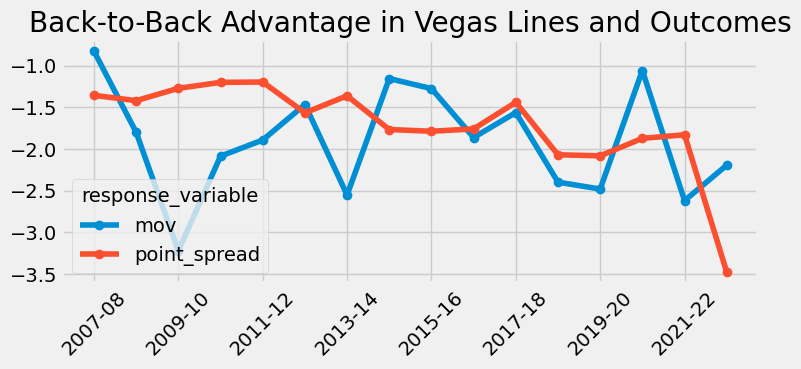

In [139]:
style.use('fivethirtyeight')

(
    pd.DataFrame(model_results)
    .pivot_table(
        index='season',
        columns='response_variable',
        values='back_to_back_advantage'
    )
    .plot(
        marker='o',
        figsize=(8,3)
    )
)

plt.xlabel('')
plt.xticks(rotation=45)

plt.title('Back-to-Back Advantage in Vegas Lines and Outcomes')
plt.show()

Let's just eyeball it and give it 1.7 points.

## Model Eval

In [142]:
hca = pd.read_csv('../data/HCA by Season.csv')

In [170]:
seasons = [
    season for season in predictions.season.unique().tolist()
    if season != "2007-08"
]

model_results = []

for season in seasons:

    subset = (
        data
        .query(f'season == "{season}"')
        .merge(
            hca,
            on='season',
            how='left'
        )
        .assign(
            back_to_back = lambda x: x['back_to_back_advantage'] *  -1.7,
            Input = lambda x: -1 * x['hca'] + x['pre_game_mov_delta'] + x['back_to_back'],
            model_sign = lambda x: np.sign(x['Input']),
            outcome_sign = lambda x: np.sign(x['mov']),
            model_right = lambda x: x['model_sign'] == x['outcome_sign']
        )
        .fillna(0)
    )

    X = subset['Input']
    y = subset['mov']

    model = sm.OLS(y, X)
    results = model.fit()

    row = {
        'season': season,
        'rsquared': results.rsquared,
        'batting_average': subset.model_right.mean()
    }
    
    model_results.append(row)

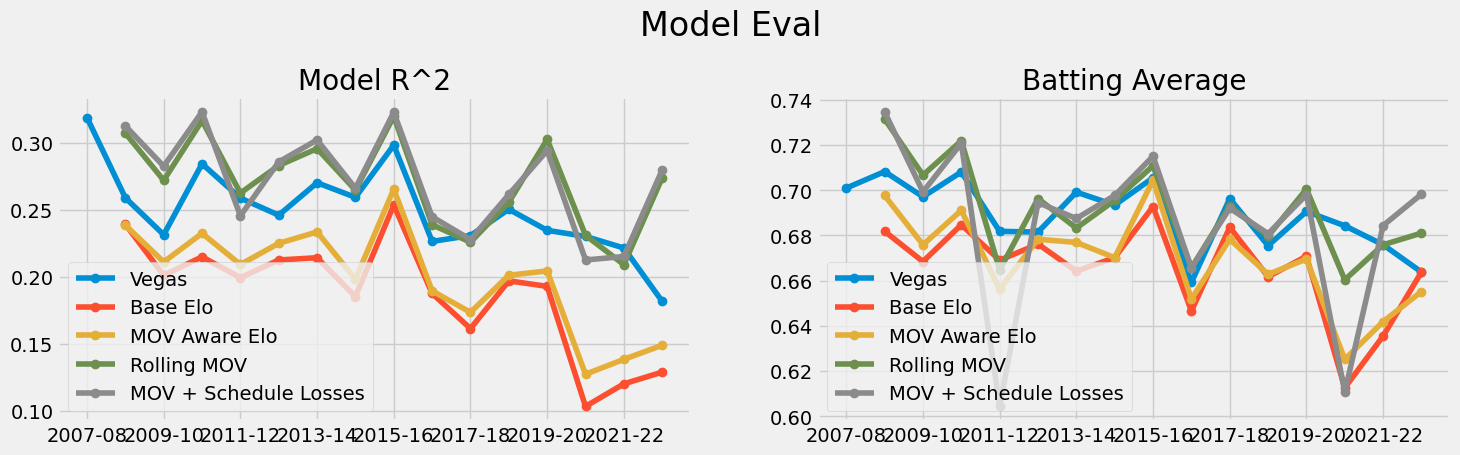

In [173]:


style.use('fivethirtyeight')

mov_results = (
    pd.DataFrame(model_results)
    .melt(
        id_vars='season',
        var_name='feature_name',
        value_name='MOV + Schedule Losses'
    )
    .merge(
        pd.read_csv('../data/MOV Results.csv'),
        how='right',
        on=['season', 'feature_name']
    )
)

fig, (ax1, ax2) = plt.subplots(1,2, figsize=(16,4))

(
    mov_results
    .query('feature_name == "rsquared"')
    .plot(
        x='season',
        y=['Vegas', 'Base Elo', 'MOV Aware Elo', 'Rolling MOV', 'MOV + Schedule Losses'],
        ax=ax1,
        marker='o',
        legend=True,
        title='Model R^2'
    )
)

(
    mov_results
    .query('feature_name == "batting_average"')
    .plot(
        x='season',
        y=['Vegas','Base Elo', 'MOV Aware Elo', 'Rolling MOV', 'MOV + Schedule Losses'],
        ax=ax2,
        marker='o',
        legend=True,
        title='Batting Average'
    )
)

plt.suptitle('Model Eval', y=1.1, size=24)

ax1.set_xlabel('')
ax2.set_xlabel('')
plt.show()